In [2]:
## Tools
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [ ]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Search wikipedia for information")
print(wiki.name)

wikipedia


In [8]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [9]:
## Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [10]:
tavily = TavilySearchResults()

In [11]:
tavily.invoke("Tell me about MCP")

[{'title': 'MCP Explained: The New Standard Connecting AI to Everything',
  'url': 'https://medium.com/@elisowski/mcp-explained-the-new-standard-connecting-ai-to-everything-79c5a1c98288',
  'content': 'Model Context Protocol (MCP) is an open standard developed by Anthropic, the company behind Claude. While it may sound technical, but the core idea is simple: give AI agents a consistent way to connect with tools, services, and data — no matter where they live or how they’re built. [...] As highlighted in Forbes, MCP is a big leap forward in how AI agents operate. Instead of just answering questions, agents can now perform useful, multi-step tasks — like retrieving data, summarizing documents, or saving content to a file.\n\nBefore MCP, each of those actions required a unique API, custom logic, and developer time to glue it all together. [...] AI agents can write code, summarize reports, even chat like humans — but when it’s time to actually do something in the real world, they stall.\n\

In [12]:
## Combining tools
tools = [arxiv, wiki, tavily]

In [13]:
from langchain_groq import ChatGroq

In [14]:
## Initialize the LLM model
llm = ChatGroq(model="qwen-qwq-32b")

In [15]:
llm.invoke("What is a brace in football?")

AIMessage(content='\n<think>\nOkay, so I need to explain what a brace is in football. Let me start by recalling what I know. I think a brace refers to a player scoring two goals in a single match. But I should make sure that\'s accurate. I remember hearing commentators say things like "the player got a brace" after they score two goals. Maybe it\'s from the idea of "two of something," like putting two items in a brace. \n\nWait, but where does the term actually come from? I\'m not entirely sure about the origin. Maybe it\'s from British English? The term "brace" in general English means a pair of something, like a brace of guns or pheasants. So applying that to two goals makes sense. \n\nBut I should also check if there are any exceptions or different uses. For example, does it only apply to goals, or could it be used for other actions like assists? Probably just goals, since I\'ve only heard it in the context of scoring. Also, is there a difference between a brace and a hat-trick? A h

In [16]:
llm_with_tools = llm.bind_tools(tools=tools)

In [17]:
response = llm_with_tools.invoke("What is the recent news on AI")

In [18]:
print(response)

content='' additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. Let me see which tool I can use here. The available functions are arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is more for academic papers, so maybe not the best for recent news. Wikipedia is for encyclopedic entries, which also might not have the latest updates. Tavily\'s search results, though, are meant for current information. That\'s probably the right choice here.\n\nI should structure the tool call with Tavily\'s function and the query as "recent news on AI". The parameters need to be a JSON object with the query. Let me make sure the syntax is correct. The name should be "tavily_search_results_json" and the arguments should have "query": "recent news on AI". \n\nDouble-checking that the function name matches exactly as provided. Yep, that\'s right. So the final tool call should be in the specified JSON format within the tool_call tags.\n', 'tool_calls': [{'id': '4m

In [20]:
llm_with_tools.invoke("What is the latest research on quantum computing?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest research on quantum computing. I need to find the most recent studies or papers on this topic. The tools available are arxiv, wikipedia, and Tavily search. \n\nFirst, arXiv is a preprint server where researchers often upload their latest papers before they\'re published in journals. That\'s probably the best source for the most recent work. Wikipedia might have general info but might not be up-to-date with the latest research. Tavily\'s search results could provide some summaries or articles, but arXiv direct access would be more authoritative here.\n\nSo I should use the arXiv function with a query like "quantum computing" to get the latest preprints. Let me check the parameters: the function requires a query string. I\'ll structure the tool call accordingly.\n', 'tool_calls': [{'id': 'jnt98c4m2', 'function': {'arguments': '{"query":"quantum computing"}', 'name': 'arxiv'}, 'type': 

In [21]:
llm_with_tools.invoke("What is machine learning")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is machine learning?" I need to figure out the best way to answer this. Let me see which tools are available. There\'s arxiv, wikipedia, and Tavily search.\n\nSince the user is asking for a definition or explanation of machine learning, Wikipedia would be a good start because it usually provides clear, concise explanations. The Wikipedia function requires a query parameter, so I should use "machine learning" as the query. That should fetch the Wikipedia page on machine learning, which likely has a detailed yet accessible introduction. \n\nAlternatively, Tavily\'s search results might give a broader range of sources, but Wikipedia is more reliable for a foundational explanation. The arXiv function is more for research papers, which might be too technical for a basic question. \n\nI\'ll go with Wikipedia first. Let me structure the tool call properly. The function name is "wikipedia" and the arg

## LANGGRAPH WORKFLOW

In [ ]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages  ## add_messages is a reducer (appends messages instead of overriding variable)

In [23]:
## State schema
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

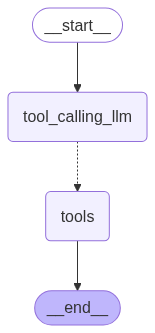

In [35]:
## Defining nodes
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

## Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Add edges
builder.add_edge(START, "tool_calling_llm")
### tools condition routes to the next node based on the nature of the latest message. to tools if a tool call,
### and to end if not a tool call
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools,
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END,
    tools_condition,
)
builder.add_edge("tools", END)

## Compile the graph
graph = builder.compile()

## Visualizing the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
from langchain_core.messages import HumanMessage

In [32]:
messages = graph.invoke({"messages": HumanMessage(content="Hello, my name is Ghost")})

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello, my name is Ghost
================================== Ai Message ==================================

Hello Ghost! Nice to meet you. How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything specific! 😊
